# Przewidywanie zapotrzebowania na energię

### W poniższym notebooku skupiliśmy się na przewidywaniu zapotrzebowania na energię w Madrycie na podstawie danych udostępnionych na Kaggle.

# Informacje na temat struktury notebooka:

##

In [2]:
import sys
from sklearn.model_selection import TimeSeriesSplit

import tensorflow.keras
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from datetime import timezone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, SimpleRNN, GRU
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
import numpy as np
import seaborn as sns
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2
GPU is available


In [6]:
def convert_types(x, from_, to_):
    for c in x.select_dtypes(include=[from_]).columns:
        x[c] = x[c].values.astype(to_)
    return x

In [4]:
# Funkcja pomocnicza
def plot_results(history):
    
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [54]:
energy_data = pd.read_csv('/Users/bartosz/aiin/archive-weather-energy/energy_dataset.csv')
weather_data = pd.read_csv('/Users/bartosz/aiin/archive-weather-energy/weather_features.csv')

In [55]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [59]:
weather_data.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Madrid,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Madrid,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Madrid,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Madrid,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Madrid,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Na początek zajmiemy się tylko miastem do którego mamy najwięcej danych - Madryt.

In [ ]:
weather_data = weather_data[weather_data.city_name == 'Madrid'].copy()

Ustawimy timezone.utc i ustawiamy index na time

In [58]:
energy_data.time = pd.to_datetime(energy_data.time).apply(lambda x: x.astimezone(timezone.utc))
energy_data = energy_data.set_index('time')
weather_data.dt_iso = pd.to_datetime(weather_data.dt_iso).apply(lambda x: x.astimezone(timezone.utc))
weather_data = weather_data.set_index('dt_iso')
weather_data = weather_data[~weather_data.index.duplicated()] #


## Na początek należy wyczyścić oba datasety i pozbyć się zbędnych, nieprzydatnych kolumn. Warto zauważyć, że są to oryginalne - niezmieniane dane, które nie do końca są przydatne w takiej formie w jakiej są. 
### Zaczniemy od pozbycia się zbędnych kolumn

In [60]:
energy_data = energy_data.drop(['forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)
weather_data = weather_data.drop(columns='city_name') 


In [61]:
weather_data = weather_data.drop(columns=list(weather_data.columns[weather_data.any() == False]) )
energy_data = energy_data.drop(columns=list(energy_data.columns[energy_data.any() == False]) )


In [62]:
energy_data.isnull().sum(axis=0)


generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [63]:
energy_data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


In [64]:
weather_data.isnull().sum(axis=0)


temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [65]:
weather_data


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,283.560,282.150,285.150,1030,88,1,280,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-12-31 19:00:00+00:00,280.120,278.150,281.150,1031,52,1,260,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-12-31 20:00:00+00:00,278.150,278.150,278.150,1030,65,1,340,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Pora zmergować oba datasety do jednego:

In [68]:
data_merged = pd.merge(energy_data, weather_data, left_index=True, right_index=True)

In [70]:
data_merged

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,1,280,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-12-31 19:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,1,260,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-12-31 20:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,1,340,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [72]:
data_merged.columns[data_merged.any() == False]


Index([], dtype='object')

In [73]:
data_merged.isna().sum()[data_merged.isna().sum() > 0]

Series([], dtype: int64)

In [76]:
data_merged = data_merged.drop(columns=['weather_icon', 'weather_main', 'weather_id', 'weather_description'])

Wydaje się, że dane są przygotowane odpowiednio.

In [78]:
data_merged.dtypes

generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
total load actual                              float64
price day ahead                                float64
price actual                                   float64
temp                                           float64
temp_min  

Przed przystąpieniem do uczenia warto zauważyć jedną rzecz - zapotrzebowanie na energię nie jest zależne od źródła pozyskiwania energii, zatem nic nie stoi na przeszkodzie, aby złączyć kilka kolumn w jedną:

In [80]:
gens = data_merged.columns[:14] 
gens

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore'],
      dtype='object')

In [81]:
data_merged['total_generation'] = data_merged[gens].sum(axis=1)

In [82]:
data_merged.dtypes

generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
total load actual                              float64
price day ahead                                float64
price actual                                   float64
temp                                           float64
temp_min  

In [83]:
data_merged = data_merged.drop(columns=gens)
data_merged.dtypes

total load actual    float64
price day ahead      float64
price actual         float64
temp                 float64
temp_min             float64
temp_max             float64
pressure               int64
humidity               int64
wind_speed             int64
wind_deg               int64
rain_1h              float64
rain_3h              float64
snow_3h              float64
clouds_all             int64
total_generation     float64
dtype: object

In [84]:
data_merged = data_merged[['total_generation'] + list(data_merged.columns[:-1])]

In [88]:
data_merged

,total_generation,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,
2014-12-31 23:00:00,28251.0,25385.0,50.10,65.41,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0
2015-01-01 00:00:00,27818.0,24382.0,48.10,64.92,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0
2015-01-01 01:00:00,26796.0,22734.0,47.33,64.48,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0
2015-01-01 02:00:00,25223.0,21286.0,42.27,59.32,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0
2015-01-01 03:00:00,24620.0,20264.0,38.41,56.04,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,26415.0,30653.0,68.85,77.02,283.560,282.150,285.150,1030,88,1,280,0.0,0.0,0.0,0
2018-12-31 19:00:00,25213.0,29735.0,68.40,76.16,280.120,278.150,281.150,1031,52,1,260,0.0,0.0,0.0,0
2018-12-31 20:00:00,23987.0,28071.0,66.88,74.30,278.150,278.150,278.150,1030,65,1,340,0.0,0.0,0.0,0


In [90]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

### Wizualizacja fragmentów szeregów czasowych dla price actual i total load actual

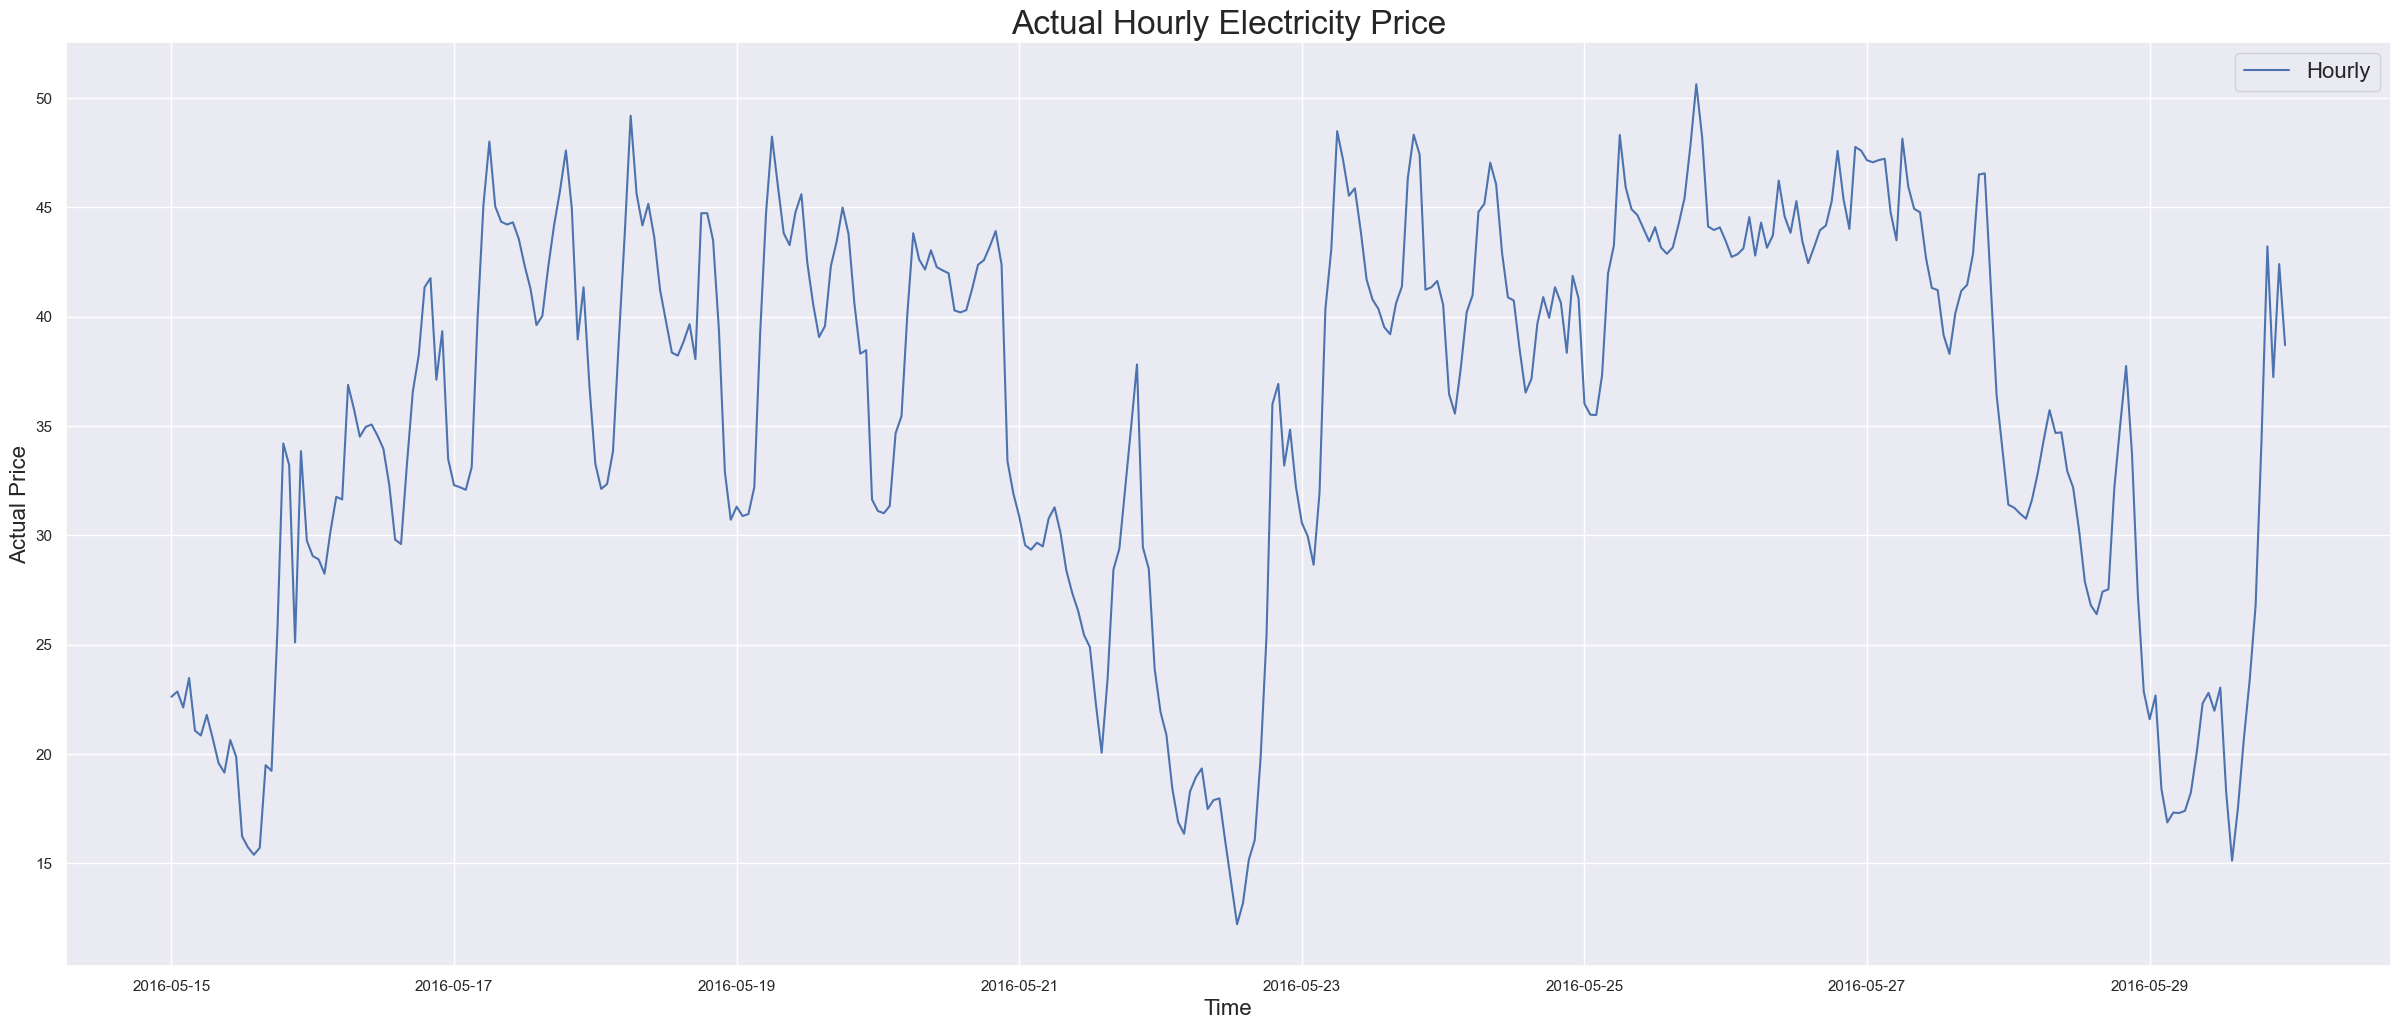

In [93]:
ax = plot_series(data_merged, 'price actual', label='Hourly', ylabel='Actual Price',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price')
plt.show()

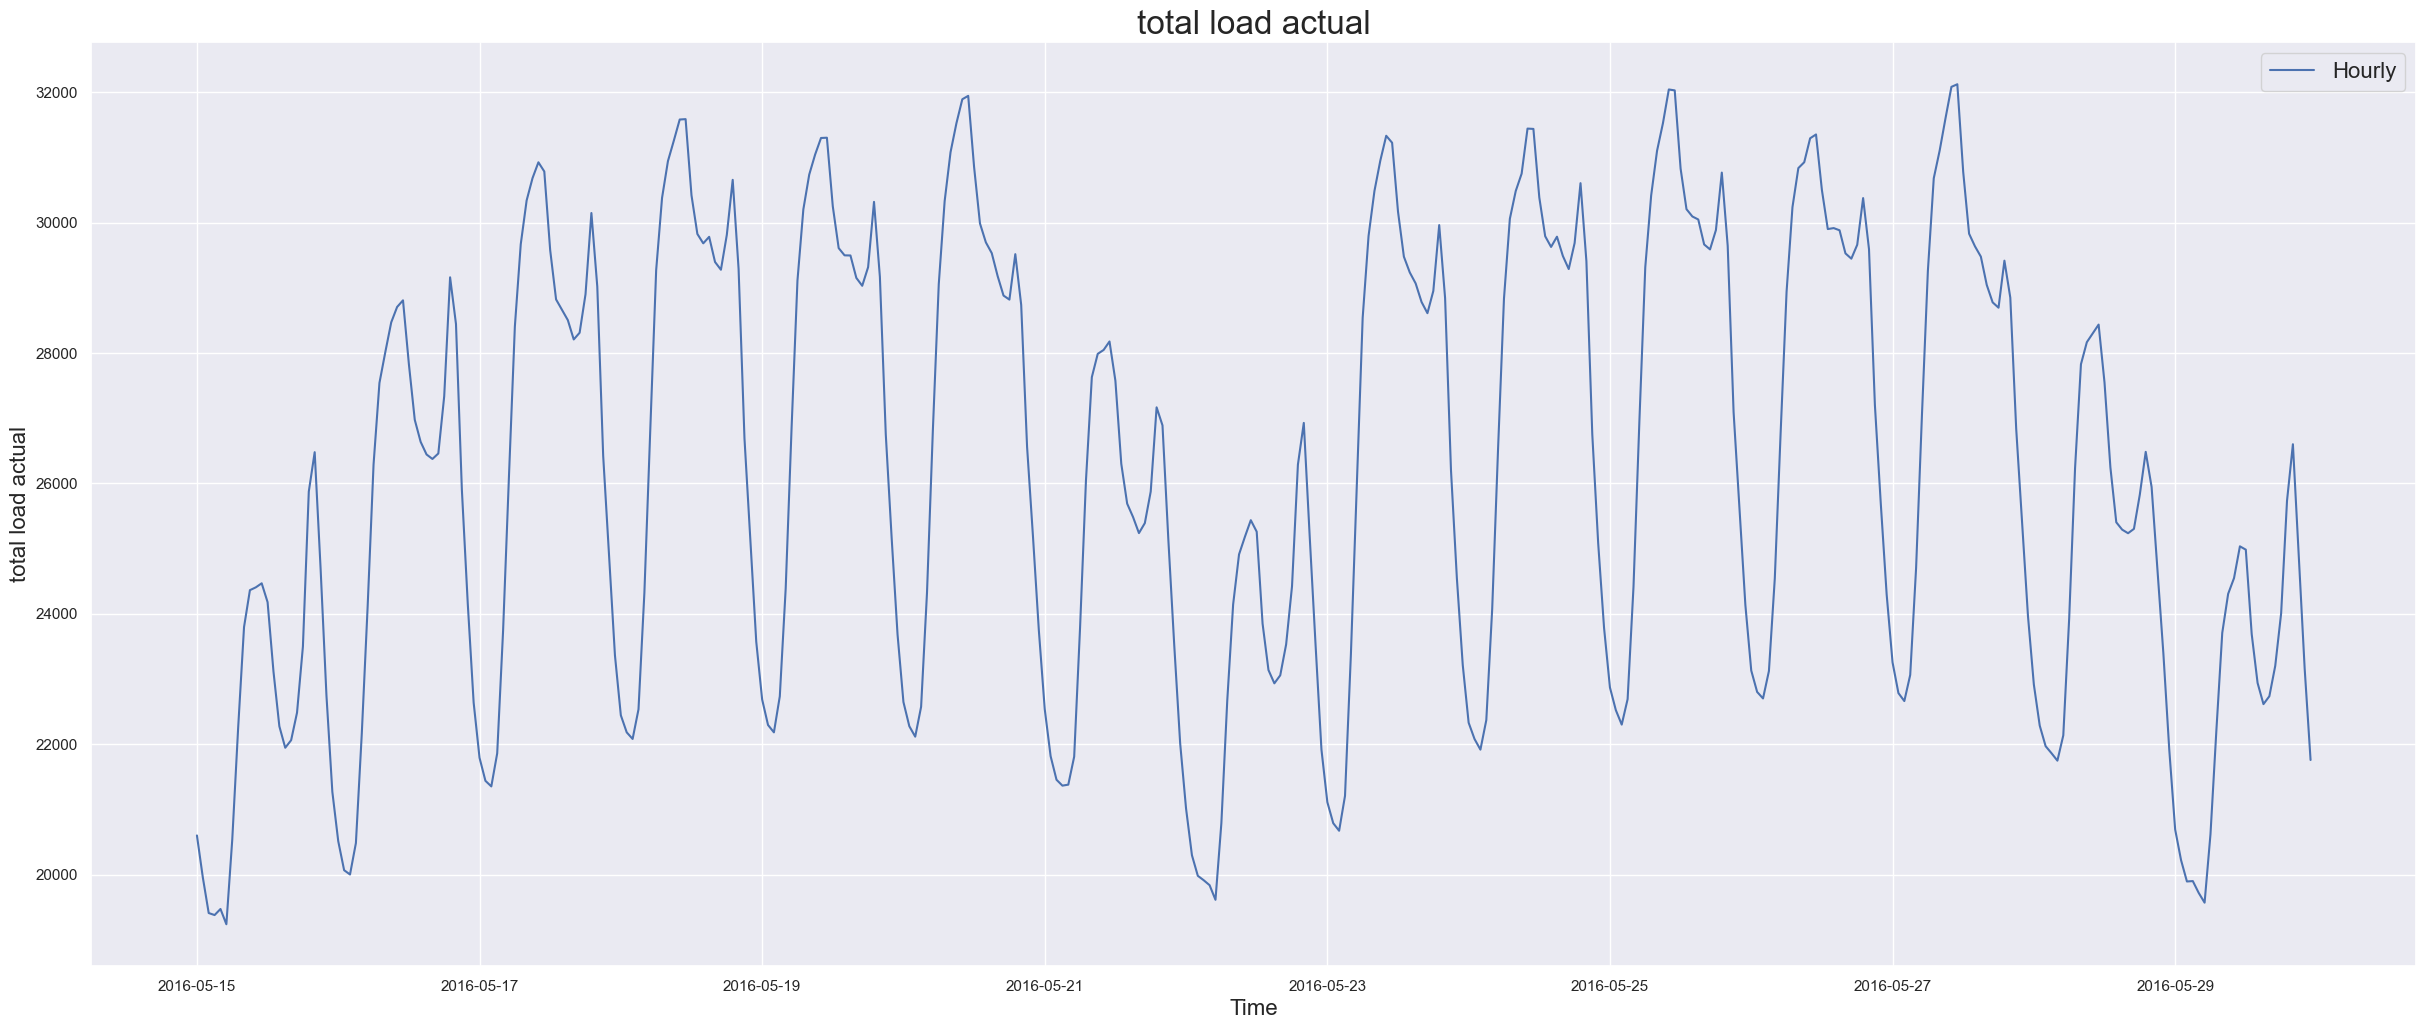

In [95]:
ax = plot_series(data_merged, 'total load actual', label='Hourly', ylabel='total load actual',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='total load actual')
plt.show()

### Dane są przygotowane - można przejść do uczenia


Teraz pora przeskalować dane.

Funkcja do podziału danych:

In [29]:
def divide_data(data_all, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(data_all) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(data_all[indices])
        labels.append(target[i + target_size])
        

    return np.array(data), np.array(labels)

In [30]:
len(data_merged)

35064

In [31]:
train_end_idx = 27000
val_end_idx = 31200
test_end_idx = 35064

X = data_merged[data_merged.columns.drop('total load actual')].values
y = data_merged['total load actual'].values
y = y.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

In [33]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

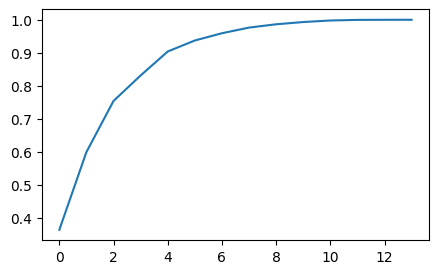

In [34]:
plt.figure(figsize=(5, 3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [35]:
pca = PCA(n_components=0.85)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [36]:
dataset_normalized = np.concatenate((X_pca, y_norm), axis=1)

In [37]:
X_train, y_train = divide_data(dataset_normalized, dataset_normalized[:, -1],
                                     0, train_end_idx, 24, 
                                     0, step=1)


In [38]:
X_val, y_val = divide_data(dataset_normalized, dataset_normalized[:, -1],
                                 train_end_idx, val_end_idx, 24, 
                                 0, step=1)


In [40]:
X_test, y_test = divide_data(dataset_normalized, dataset_normalized[:, -1],
                                   val_end_idx, test_end_idx, 24, 
                                   0, step=1)


## Dane są przeskalowane, można przejść do uczenia

### Na początek zobaczmy jak radzi sobie LSTM

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
optimizer = tf.keras.optimizers.Adam()

model_LSTM_2 = Sequential()
model_LSTM_2.add(LSTM(128, input_shape = X_train.shape[-2:]))
model_LSTM_2.add(Flatten())
model_LSTM_2.add(Dense(64, activation='relu'))
model_LSTM_2.add(Dropout(0.1))
model_LSTM_2.add(Dense(1))
model_LSTM_2.compile(loss=loss, metrics=metric, optimizer=optimizer)

history = model_LSTM_2.fit(X_train,y_train, epochs=120, validation_data=(X_val, y_val))


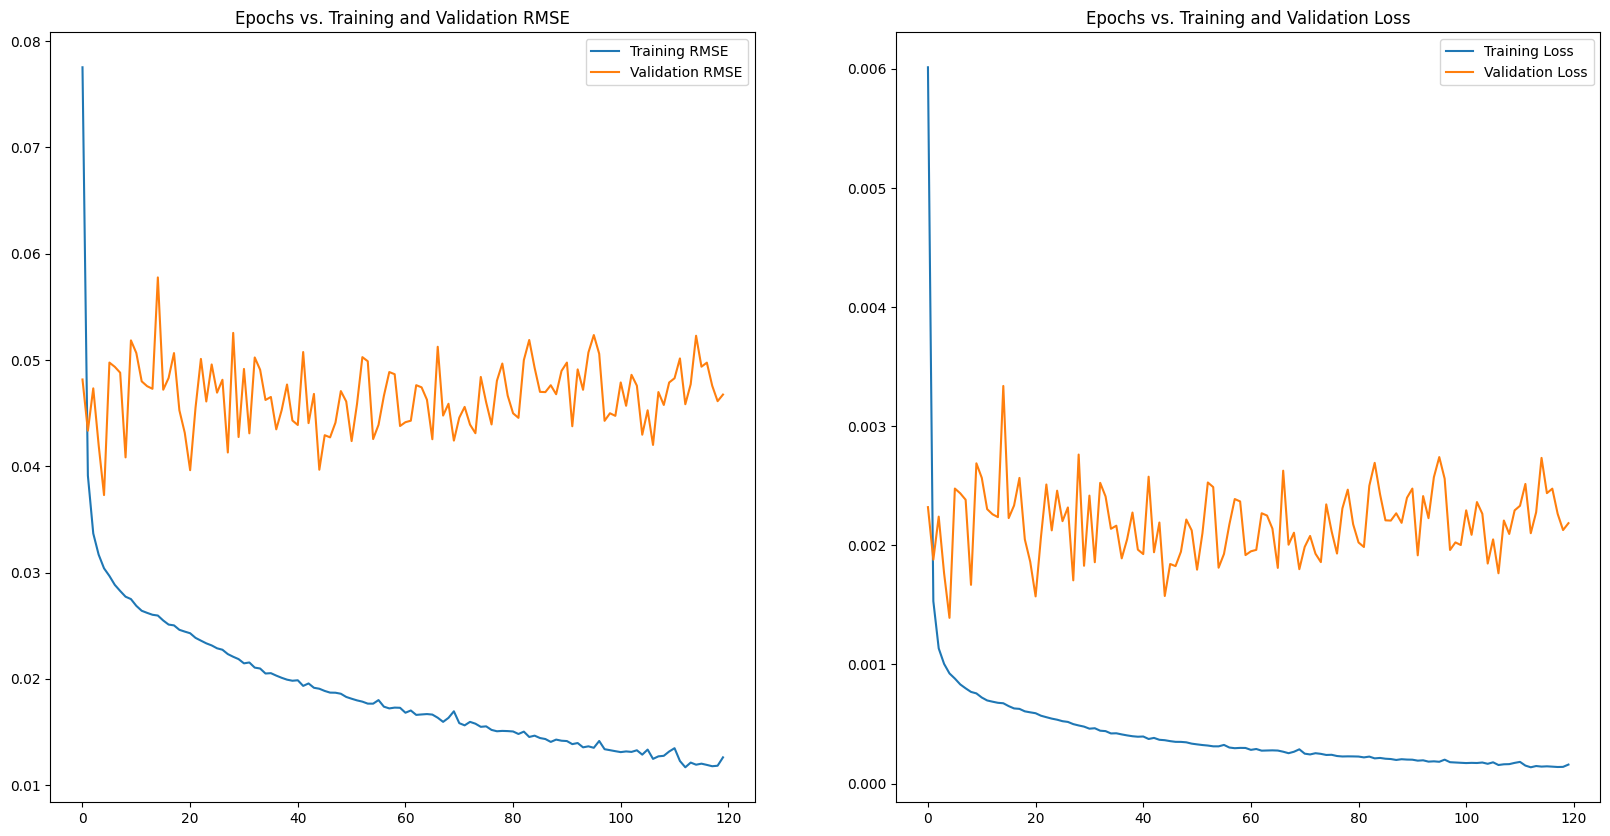

In [50]:
plot_results(history)

Można zauważyć słaby performance na zbiorze walidacyjnym.

Spróbujmy teraz odpalić inną architekturę LSTM i dodam early stopping

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
optimizer = tf.keras.optimizers.legacy.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model_LSTM_4 = Sequential()
model_LSTM_4.add(LSTM(100, input_shape = X_train.shape[-2:]))
model_LSTM_4.add(Flatten())
model_LSTM_4.add(Dense(180, activation='relu'))
model_LSTM_4.add(Dropout(0.1))
model_LSTM_4.add(Dense(1))
model_LSTM_4.compile(loss=loss, metrics=metric, optimizer=optimizer)

history_4 = model_LSTM_4.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val),callbacks=[early_stopping])


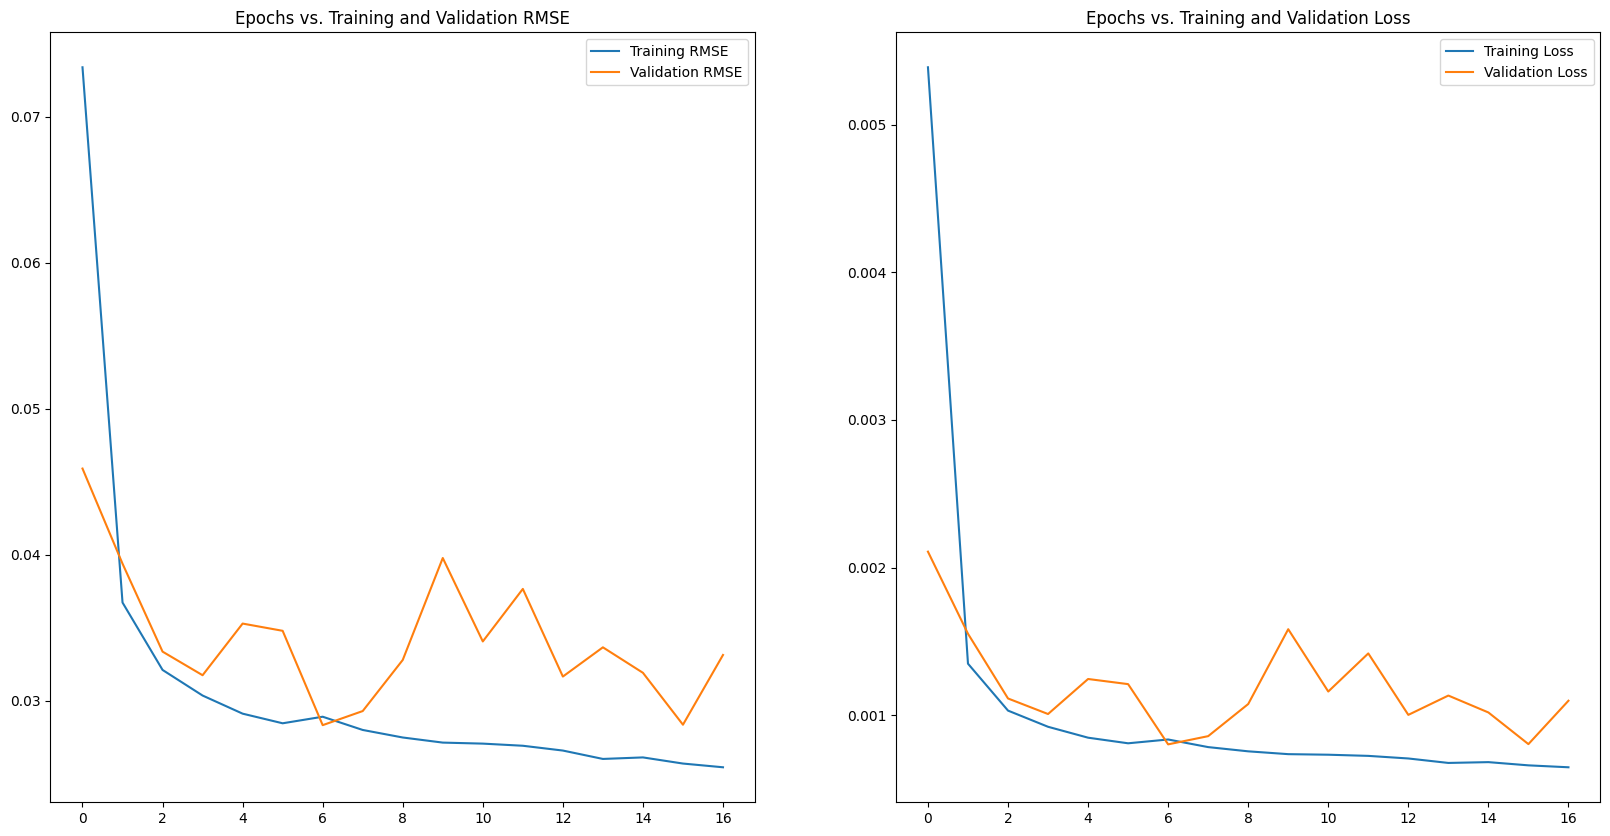

In [42]:
plot_results(history_4)

Zdecydowanie lepsze wyniki! zbiór walidacyjny zdaje się bardziej podążać za treningowym. Zobaczmy teraz dla odmiany SimpleRNN

## Testowanie SimpleRNN

In [ ]:
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)]

model_Simple_3 = Sequential()
model_Simple_3.add(SimpleRNN(64, return_sequences=True, input_shape = X_train.shape[-2:]))
model_Simple_3.add(Dense(16, activation='relu'))
model_Simple_3.add(Dropout(0.1))
model_Simple_3.add(Dense(1))
model_Simple_3.compile(loss=loss, metrics=metric, optimizer=optimizer)

history_Simple_3 = model_Simple_3.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=early_stopping)

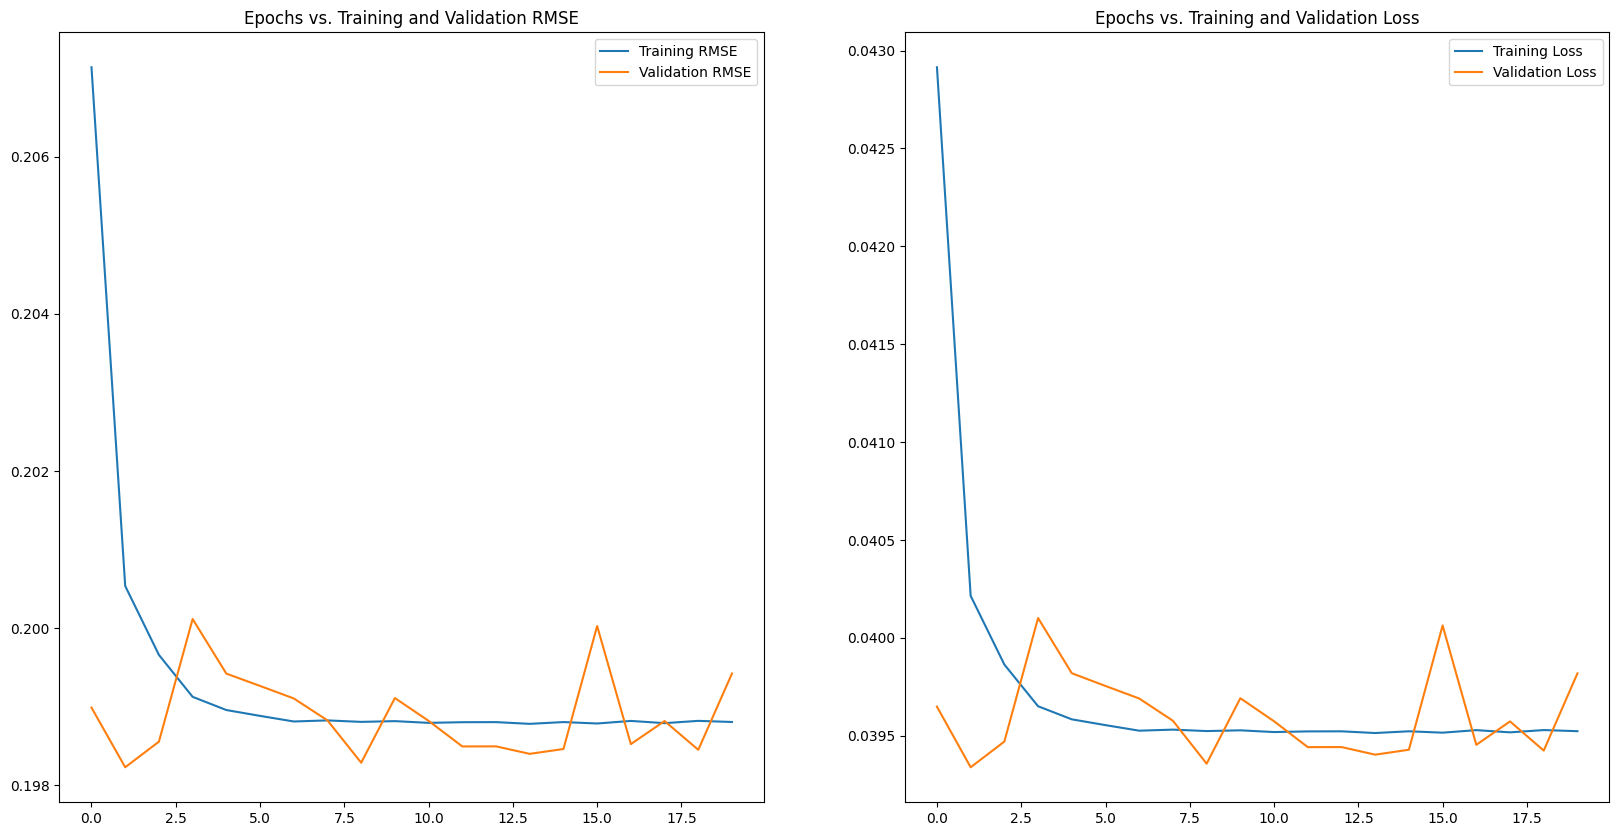

In [44]:
plot_results(history_Simple_3)

SimpleRNN nie radzi sobie najlepiej, w porównaniu do LSTM jest o wiele większy RMSE, za to znacznie mniejszy overfitting.Loss także wysokie.

## Testowanie GRU

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
optimizer = tf.keras.optimizers.legacy.Adam()

model_GRU_1 = Sequential()
model_GRU_1.add(GRU(100, input_shape = X_train.shape[-2:]))
model_GRU_1.add(Flatten())
model_GRU_1.add(Dense(180, activation='relu'))
model_GRU_1.add(Dropout(0.1))
model_GRU_1.add(Dense(1))
model_GRU_1.compile(loss=loss, metrics=metric, optimizer=optimizer)

history_gru_1 = model_GRU_1.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val))


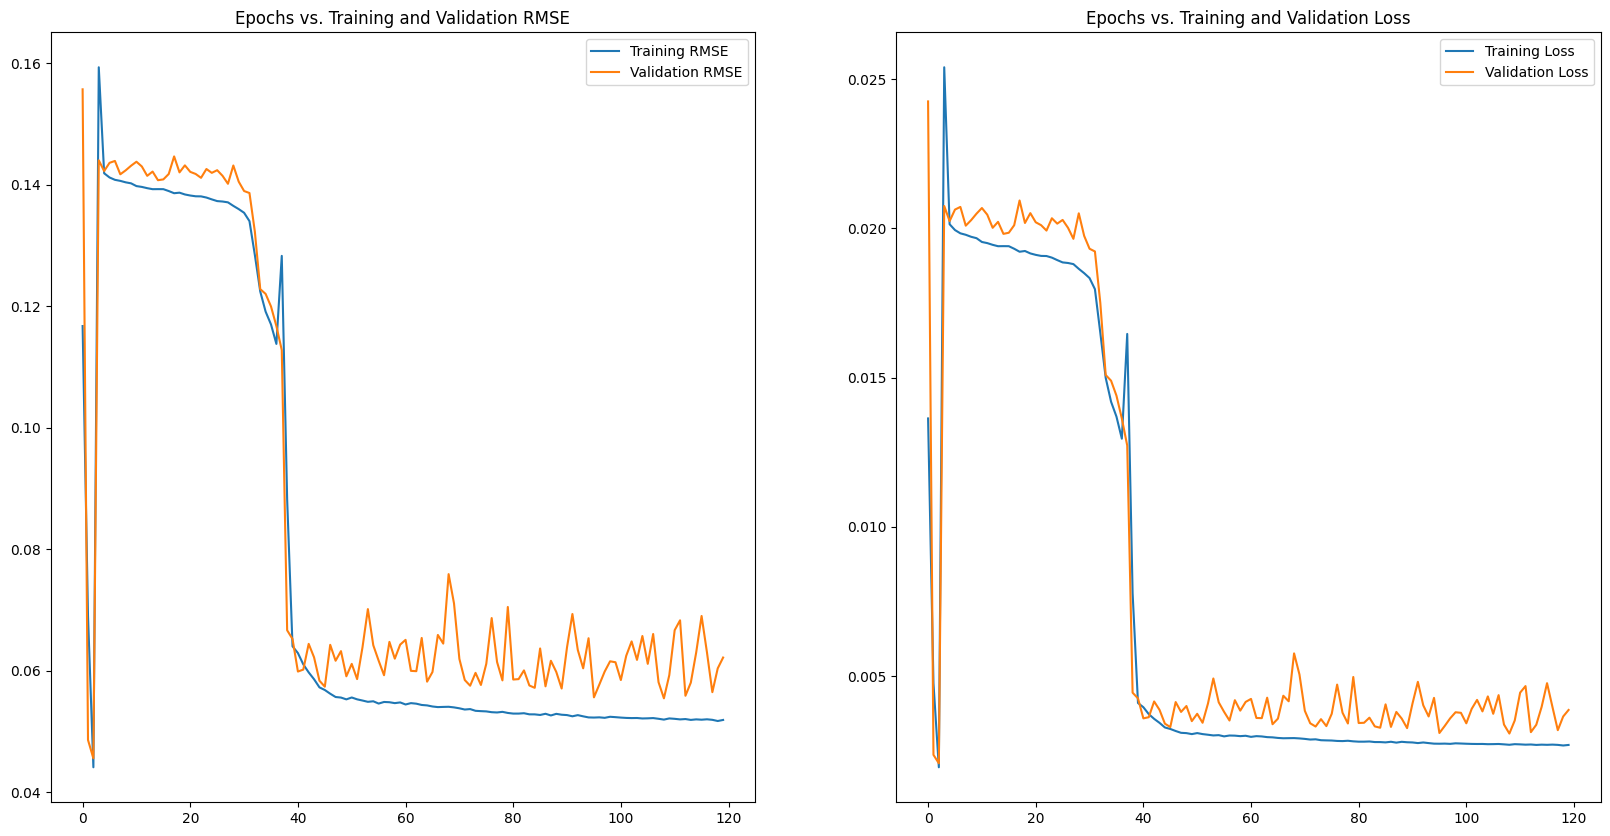

In [46]:
plot_results(history_gru_1)

W pierwszych 40 epokach sieć miała problemy, ale po 40 epokach wyniki zaczęły wyglądać dość dobrze. Niskie loss, overfitting mniejszy niż w LSTM